原始資料筆數: 30326
清洗後剩餘筆數: 30220
✅ 已將目標值 y 全部轉換為絕對值 (只預測電流大小)
總資料筆數: 30220
獨特的特徵組合數 (Groups): 672
✅ 切分成功！訓練集與測試集的特徵組合完全獨立 (無 Data Leakage)。
🚀 開始訓練...

================ 結果 (Group-Split 嚴格版) ================
📌 MAPE (誤差率): 81.97%
📌 MAE  (平均誤差): 2.0211 (安培)
📌 R2 Score (決定係數): 0.0797


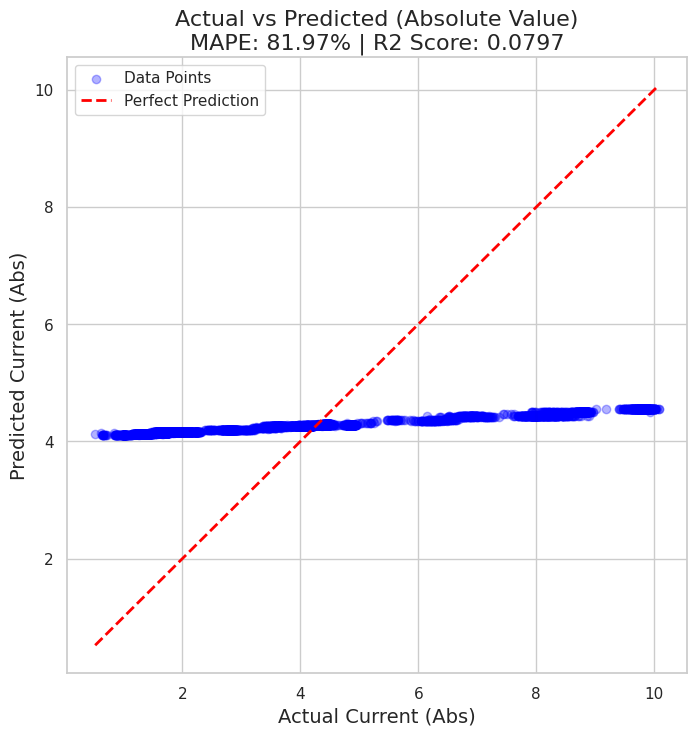

/tmp/ipython-input-2488631900.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_15, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: G

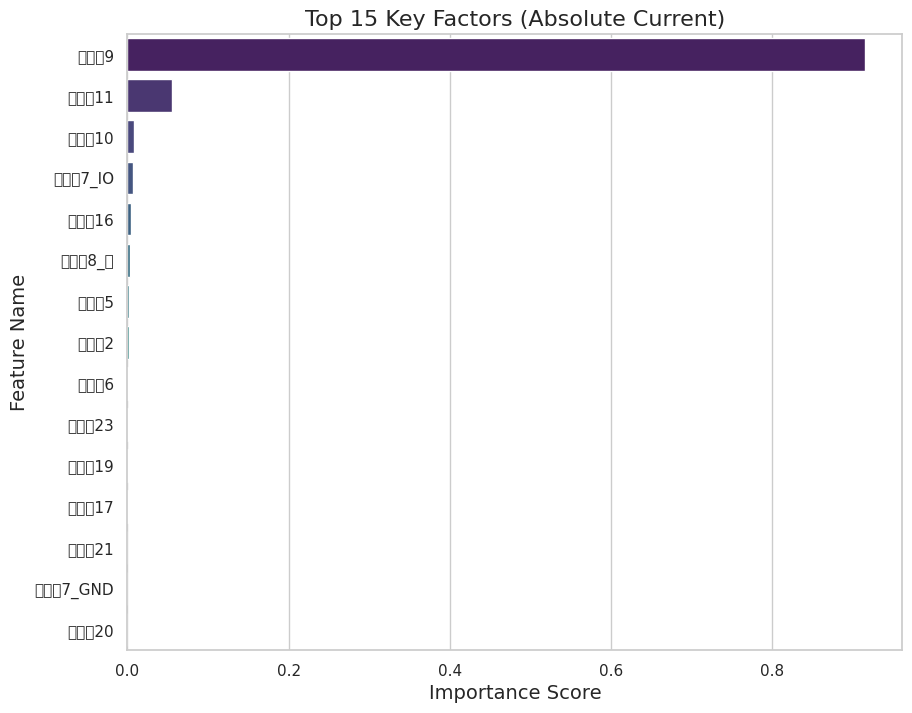


📊 特徵重要性詳細數值 (前 20 名)：
--------------------------------------------------
名次    | 特徵名稱                           | 貢獻度 (分數)
--------------------------------------------------
No.1   | 特徵值9                           | 0.915366
No.2   | 特徵值11                          | 0.055163
No.3   | 特徵值10                          | 0.008070
No.4   | 特徵值7_IO                        | 0.006929
No.5   | 特徵值16                          | 0.004852
No.6   | 特徵值8_正                         | 0.002758
No.7   | 特徵值5                           | 0.001869
No.8   | 特徵值2                           | 0.001763
No.9   | 特徵值6                           | 0.001022
No.10  | 特徵值23                          | 0.000839
No.11  | 特徵值19                          | 0.000747
No.12  | 特徵值17                          | 0.000441
No.13  | 特徵值21                          | 0.000137
No.14  | 特徵值7_GND                       | 0.000029
No.15  | 特徵值20                          | 0.000016
No.16  | 特徵值18                          | 0.000000
No.17  | 

In [30]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GroupShuffleSplit
# 👇 修改這裡：加入 r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os

# ==========================================
# 解決中文字型問題
# ==========================================
plt.rcParams['axes.unicode_minus'] = False

# 1. 讀取資料
file_path = 'merged_file.xlsx'
df = pd.read_excel(file_path)
target_col_name = 'Output 1'

print(f"原始資料筆數: {len(df)}")

# ==========================================
# 步驟 1: 先清洗 df
# ==========================================
df[target_col_name] = pd.to_numeric(df[target_col_name], errors='coerce')
df = df.dropna(subset=[target_col_name])
df = df[df[target_col_name].abs() > 0.0001]
df = df.reset_index(drop=True)

print(f"清洗後剩餘筆數: {len(df)}")

# ==========================================
# 步驟 2: 切分 X 和 y
# ==========================================
y = df[target_col_name].abs() # 取絕對值
print("✅ 已將目標值 y 全部轉換為絕對值 (只預測電流大小)")

ignore_list = [target_col_name, 'Output 2', 'Output 3', 'Output 4', 'Output 5', 'Unnamed: 0']
cols_to_drop = [c for c in ignore_list if c in df.columns]
X_raw = df.drop(columns=cols_to_drop)

# ==========================================
# 步驟 3: 特徵處理
# ==========================================
numeric_X = X_raw.copy()
for col in numeric_X.columns:
    numeric_X[col] = pd.to_numeric(numeric_X[col], errors='coerce')

for col in X_raw.columns:
    if numeric_X[col].isna().mean() > 0.5:
        numeric_X[col] = X_raw[col]
    else:
        numeric_X[col] = numeric_X[col].fillna(0)

X_final = pd.get_dummies(numeric_X)

# ==========================================
# 步驟 4: 基於 Group 的訓練切分
# ==========================================
groups = X_final.groupby(list(X_final.columns)).ngroup()

print(f"總資料筆數: {len(X_final)}")
print(f"獨特的特徵組合數 (Groups): {groups.nunique()}")

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_final, y, groups=groups))

X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# 驗證漏題
train_groups = set(groups.iloc[train_idx])
test_groups = set(groups.iloc[test_idx])
overlap = train_groups.intersection(test_groups)

if len(overlap) == 0:
    print("✅ 切分成功！訓練集與測試集的特徵組合完全獨立 (無 Data Leakage)。")
else:
    print(f"❌ 切分失敗！有 {len(overlap)} 組特徵同時出現在兩邊。")

# ==========================================
# 開始訓練
# ==========================================
model = XGBRegressor(n_estimators=1, learning_rate=0.05, n_jobs=-1, random_state=42)
print("🚀 開始訓練...")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# 👇 計算各項指標 (包含 R2)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  # <--- 新增這一行

print(f"\n================ 結果 (Group-Split 嚴格版) ================")
print(f"📌 MAPE (誤差率): {mape * 100:.2f}%")
print(f"📌 MAE  (平均誤差): {mae:.4f} (安培)")
print(f"📌 R2 Score (決定係數): {r2:.4f}") # <--- 新增這一行
print(f"===========================================================")

# 設定繪圖風格
sns.set(style="whitegrid")

# ==========================================
# 圖表 1: 預測值 vs 實際值 (散佈圖)
# ==========================================
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue', label='Data Points')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# 👇 標題新增 R2 顯示
plt.title(f'Actual vs Predicted (Absolute Value)\nMAPE: {mape*100:.2f}% | R2 Score: {r2:.4f}', fontsize=16)
plt.xlabel('Actual Current (Abs)', fontsize=14)
plt.ylabel('Predicted Current (Abs)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 圖表 2: 特徵重要性排行
# ==========================================
feature_importance = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_15 = feature_importance.head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_15, palette='viridis')
plt.title('Top 15 Key Factors (Absolute Current)', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.show()

# ==========================================
# 步驟 5: 輸出具體的貢獻數值
# ==========================================
print("\n📊 特徵重要性詳細數值 (前 20 名)：")
print("--------------------------------------------------")
print(f"{'名次':<5} | {'特徵名稱':<30} | {'貢獻度 (分數)'}")
print("--------------------------------------------------")

top_20 = feature_importance.head(20).reset_index(drop=True)
for index, row in top_20.iterrows():
    print(f"No.{index+1:<3} | {row['Feature']:<30} | {row['Importance']:.6f}")
print("--------------------------------------------------")

output_filename = "特徵貢獻度排行_絕對值版.xlsx"
feature_importance.to_excel(output_filename, index=False)
print(f"\n💾 完整清單已存檔為: {output_filename}")

分組 絕對值

✅ 已設定 y 為原始電流值 (包含正負號)
🔄 執行隨機切分 (Random Split)...

================ 結果 (回到 Ex1: 隨機 + 正負號) ================
📌 MAPE (誤差率): 2.62%
📌 R2 Score: 0.9956


/tmp/ipython-input-3641732062.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


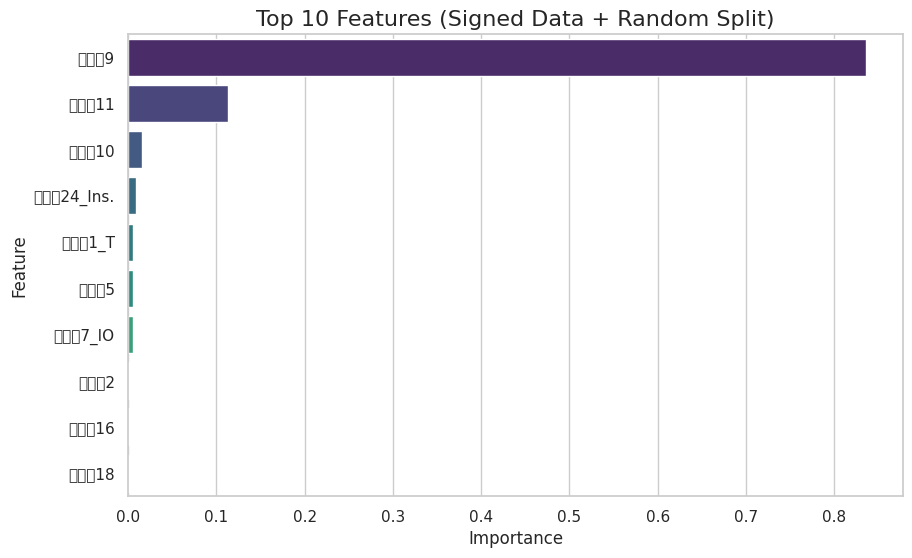


前 5 名特徵 (驗證是否變回 Feature 8):
       Feature  Importance
3         特徵值9    0.835993
5        特徵值11    0.113730
4        特徵值10    0.015308
37  特徵值24_Ins.    0.009387
19      特徵值1_T    0.006045


In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 設定繪圖風格與字型
plt.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid")

# 1. 讀取資料
file_path = 'merged_file.xlsx'
df = pd.read_excel(file_path)
target_col_name = 'Output 1'

# 2. 清洗資料
df[target_col_name] = pd.to_numeric(df[target_col_name], errors='coerce')
df = df.dropna(subset=[target_col_name])
# 過濾雜訊，但「保留負數」
df = df[df[target_col_name].abs() > 0.0001]
df = df.reset_index(drop=True)

# ==========================================
# 🛑 修正點 1：不取絕對值了！保留正負號 (回到 Ex1 狀態)
# ==========================================
y = df[target_col_name].abs()  # <--- 注意這裡沒有 .abs()
print("✅ 已設定 y 為原始電流值 (包含正負號)")

# 3. 準備 X
ignore_list = [target_col_name, 'Output 2', 'Output 3', 'Output 4', 'Output 5', 'Unnamed: 0']
cols_to_drop = [c for c in ignore_list if c in df.columns]
X_raw = df.drop(columns=cols_to_drop)

# 4. 特徵處理 (轉數字 + One-Hot)
numeric_X = X_raw.copy()
for col in numeric_X.columns:
    numeric_X[col] = pd.to_numeric(numeric_X[col], errors='coerce')

for col in X_raw.columns:
    if numeric_X[col].isna().mean() > 0.5:
        numeric_X[col] = X_raw[col]
    else:
        numeric_X[col] = numeric_X[col].fillna(0)

X_final = pd.get_dummies(numeric_X)

# ==========================================
# 🛑 修正點 2：使用隨機切分 (Random Split)
# ==========================================
print("🔄 執行隨機切分 (Random Split)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# 5. 訓練模型
model = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. 計算指標
# 注意：原本的 MAPE 公式在遇到 0 或正負號混雜時有時會不穩定，但這裡我們直接算
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n================ 結果 (回到 Ex1: 隨機 + 正負號) ================")
print(f"📌 MAPE (誤差率): {mape * 100:.2f}%")
print(f"📌 R2 Score: {r2:.4f}")

# ==========================================
# 圖表：特徵重要性 (預期 Feature 8 會衝回第一名)
# ==========================================
feature_importance = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Features (Signed Data + Random Split)', fontsize=16)
plt.show()

# 印出前 5 名數值驗證
print("\n前 5 名特徵 (驗證是否變回 Feature 8):")
print(feature_importance.head(5))


隨機分